In [47]:
import pandas as pd
import numpy as np
import dill as pickle
from sklearn import neighbors, cross_validation, grid_search, base
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import cross_validation
from sklearn import neighbors
from sklearn.pipeline import Pipeline
from sklearn import grid_search
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [3]:
df2015 = pd.DataFrame(pd.read_csv('data2015_analyzed.csv'))
print df2015.columns.values.tolist()

['station_id', 'station_name', 'latitude', 'longitude', 'malecount', 'femalecount', 'SUM', 'age20', 'age25', 'age30', 'age35', 'age40', 'age45', 'age50', 'age55', 'age60', 'age65', 'age70', 'age75', 'age80', 'age85', 'age90', 'age95', 'age100', 'age101', 'age20m', 'age20f', 'age25m', 'age25f', 'age30m', 'age30f', 'age35m', 'age35f', 'age40m', 'age40f', 'age45m', 'age45f', 'age50m', 'age50f', 'age55m', 'age55f', 'age60m', 'age60f', 'age65m', 'age65f', 'age70m', 'age70f', 'age75m', 'age75f', 'age80m', 'age80f', 'age85m', 'age85f', 'age90m', 'age90f', 'age95m', 'age95f', 'age100m', 'age100f', 'age101m', 'age101f']


In [ ]:
# Combine the 12 file for each month in 2015  
combined = open("combined2015.csv","a")

# first file with header
for line in open("201501-citibike-tripdata.csv"):
    combined.write(line)

# rest of the file ignore header
for i in range(2,13):
    f = open("2015"  + str("%02d" %(i)) + "-citibike-tripdata.csv")
    f.next()
    for line in f:
        combined.write(line)
    f.close()
combined.close()

In [46]:
df2015['age65bm'] = df2015['age70m'] + df2015['age75m'] +df2015['age80m'] +df2015['age85m']+df2015['age90m']+df2015['age95m']+df2015['age100m']+df2015['age101m']
df2015['age65bf'] = df2015['age70f'] + df2015['age75f'] +df2015['age80f'] +df2015['age85f']+df2015['age90f']+df2015['age95f']+df2015['age100f']+df2015['age101f']
df2015['maleallage'] =  df2015['age20m'] + df2015['age25m'] +df2015['age30m'] +df2015['age35m']+df2015['age40m']+df2015['age45m']+df2015['age50m']+df2015['age55m']+df2015['age60m']+df2015['age65m'] +df2015['age70m'] +df2015['age75m']+df2015['age80m'] +df2015['age85m']+df2015['age90m']+df2015['age95m']+df2015['age100m']+df2015['age101m']
df2015['femaleallage'] =df2015['age20f'] + df2015['age25f'] +df2015['age30f'] +df2015['age35f']+df2015['age40f']+df2015['age45f']+df2015['age50f']+df2015['age55f']+df2015['age60f']+df2015['age65f'] +df2015['age70f'] +df2015['age75f']+df2015['age80f'] +df2015['age85f']+df2015['age90f']+df2015['age95f']+df2015['age100f']+df2015['age101f']
df2015['allage'] = df2015['maleallage']+df2015['femaleallage'] 

In [8]:
# save the data to pickle
output = open('df2015.pkl', 'wb')
pickle.dump(df2015, output)
output.close()

In [9]:
# load the data
df2015 = pickle.load(open('df2015.pkl'))
print type(df2015)

<class 'pandas.core.frame.DataFrame'>


In [11]:
# define a function to change dataframe to lists
def lists_list(lists):
    flattened = [val for sublist in lists for val in sublist]
    return flattened

In [60]:
# find the optimal parameters
def grid_score_plotter(cv,param):
  cv_accuracy = pd.DataFrame.from_records(
      [(score.parameters[param],
        score.mean_validation_score)
       for score in cv.grid_scores_],
  columns=[param, 'accuracy'])

  plt.plot(cv_accuracy[param], cv_accuracy.accuracy)
  plt.xlabel('Number of Neighbors',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.show()


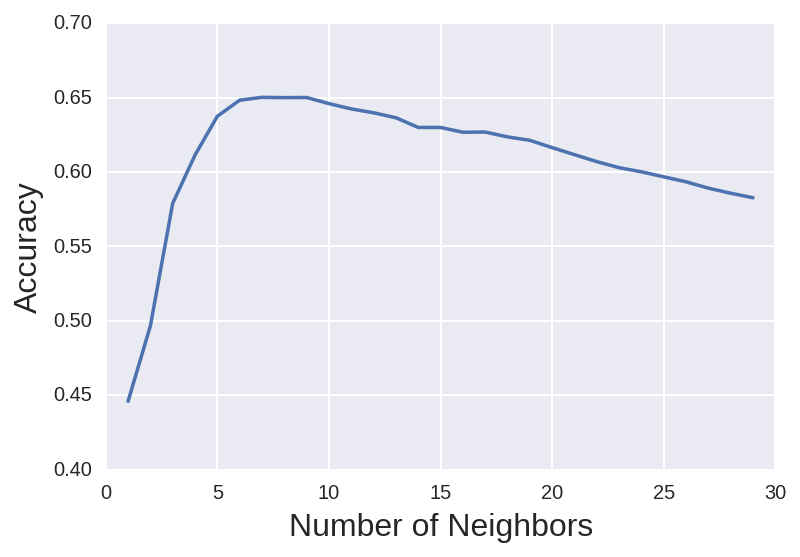

0.650174040337
{'knn__n_neighbors': 7}
<function score at 0x7fa4807bd398>


In [65]:
#build transformer and estimator

df = df2015

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
  """
  Select columns of data from nd array
  """
  def __init__(self, columns):
    ''' columns must be list of strings '''
    if type(columns) is list and type(columns[0]) is str:
      self.columns = columns
    else:
      print "columns must be string or list of strings"
    
  def fit(self, X, y):
    return self

  def transform(self, X):
    ''' Assume X is pandas dataframe or dict-like '''
    if isinstance(X,dict):
      return [X[col] for col in self.columns]
    else:
      return X[self.columns].as_matrix()



knn_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(columns = ['longitude','latitude'])),
    ('knn', neighbors.KNeighborsRegressor())
  ])

lat_long_model = grid_search.GridSearchCV(
                    knn_pipe, 
                    param_grid={"knn__n_neighbors": range(1,30,1)}, 
                    cv=cross_validation.ShuffleSplit(
                        len(df.index), n_iter=25, 
                        test_size=0.2, random_state=25) 
                  )


# change the column selection and save model to sepecfic pickle file
lat_long_model.fit(df,df['age35f'])

grid_score_plotter(lat_long_model,'knn__n_neighbors')

bestmodel = lat_long_model.best_estimator_

regresserfile = open('age35f.pkl', 'wb')
pickle.dump(bestmodel, regresserfile)
regresserfile.close()

print lat_long_model.best_score_
print lat_long_model.best_params_
print bestmodel.score

In [16]:
# calculate the average value for each group
averagemen = [int(round(df2015['age20m'].mean())),
              int(round(df2015['age25m'].mean())),
              int(round(df2015['age30m'].mean())),
              int(round(df2015['age35m'].mean())),
              int(round(df2015['age40m'].mean())),
              int(round(df2015['age45m'].mean())),
              int(round(df2015['age50m'].mean())),
              int(round(df2015['age55m'].mean())),
              int(round(df2015['age60m'].mean())),
              int(round(df2015['age65m'].mean())),
              int(round(df2015['age65bm'].mean()))]

averagewomen = [int(round(df2015['age20f'].mean())),
                int(round(df2015['age25f'].mean())),
                int(round(df2015['age30f'].mean())),
                int(round(df2015['age35f'].mean())),
                int(round(df2015['age40f'].mean())),
                int(round(df2015['age45f'].mean())),
                int(round(df2015['age50f'].mean())),
                int(round(df2015['age55f'].mean())),
                int(round(df2015['age60f'].mean())),
                int(round(df2015['age65f'].mean())),
                int(round(df2015['age65bf'].mean())),]
allmen = df2015['maleallage'].sum()
allwomen = df2015['femaleallage'].sum()
print averagemen, averagewomen, allmen, allwomen

[210, 1635, 4751, 5157, 3836, 3211, 2918, 2302, 1583, 948, 533] [62, 670, 1789, 1726, 1068, 750, 719, 620, 502, 219, 99] 13216904 4013529


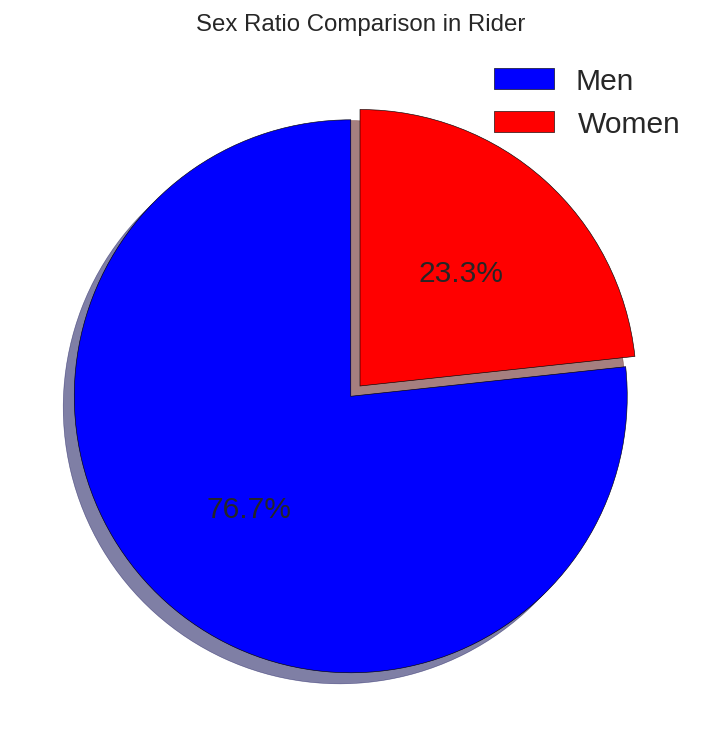

In [27]:
# plot rider sex comparison
matplotlib.rcParams['font.size'] = 15
labels   = ['Men','Women']
fracs = [df2015['maleallage'].sum(),df2015['femaleallage'].sum()]
labels = ['Men','Women']
explode=(0.05, 0)
colors  = ["blue","red"]
fig = plt.figure(1, figsize=(6,6)) #figsize=(6,6) 控制图的大小
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
def autopct_func():
    return '%1.1f%%'
res = ax.pie(fracs,
             #labels=labels,
             colors=colors,
             explode=explode,
             autopct=autopct_func(),
             pctdistance=0.55,
             shadow=True, 
             labeldistance=1.1,
             startangle=90,
             radius=1,
             )
plt.legend(labels, loc=1, shadow=True,fontsize=15)
plt.title('Sex Ratio Comparison in Rider')
#plt.title('Rider Sex: Men Vs Women', bbox={'facecolor':'1', 'pad':15})

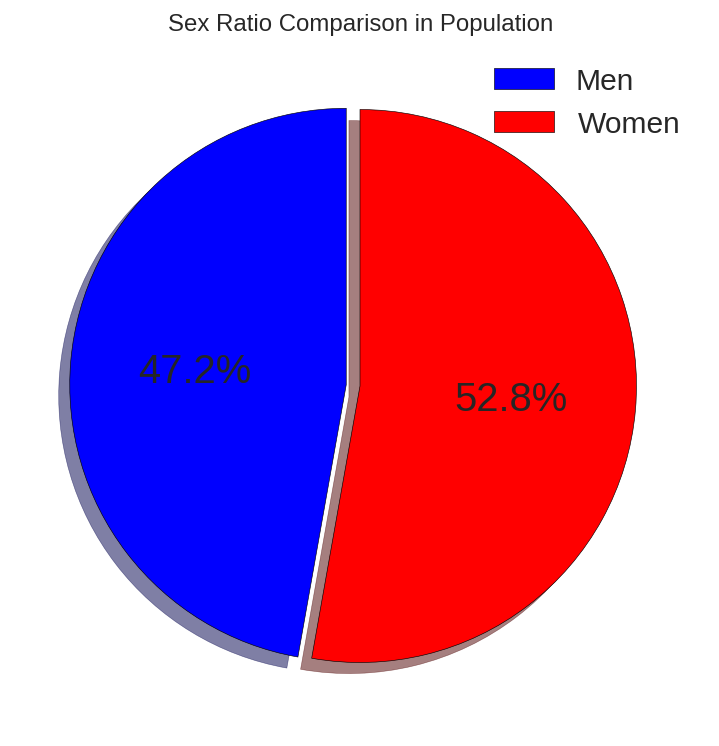

In [28]:
# plot sex comparison in the population of manhantan
matplotlib.rcParams['font.size'] = 20 
labels   = ['Men','Women']
fracs = [772376,863892]
labels = ['Men','Women']
explode=(0.05, 0)
colors  = ["blue","red"]
fig = plt.figure(1, figsize=(6,6)) #figsize=(6,6) 控制图的大小
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
def autopct_func():
    return '%1.1f%%'
res = ax.pie(fracs,
             #labels=labels,
             colors=colors,
             explode=explode,
             autopct=autopct_func(),
             pctdistance=0.55,
             shadow=True, 
             labeldistance=1.1,
             startangle=90,
             radius=1,
             )
plt.legend(labels, loc=1, shadow=True,fontsize=15)
plt.title('Sex Ratio Comparison in Population')

In [29]:
# get the prediction value based on the optimized parameter for each group
age20m_model = pickle.load(open('age20m.pkl'))
age20f_model = pickle.load(open('age20f.pkl'))
age25m_model = pickle.load(open('age25m.pkl'))
age25f_model = pickle.load(open('age25f.pkl'))
age30m_model = pickle.load(open('age30m.pkl'))
age30f_model = pickle.load(open('age30f.pkl'))
age35m_model = pickle.load(open('age35m.pkl'))
age35f_model = pickle.load(open('age35f.pkl'))
age40m_model = pickle.load(open('age40m.pkl'))
age40f_model = pickle.load(open('age40f.pkl'))
age45m_model = pickle.load(open('age45m.pkl'))
age45f_model = pickle.load(open('age45f.pkl'))
age50m_model = pickle.load(open('age50m.pkl'))
age50f_model = pickle.load(open('age50f.pkl'))
age55m_model = pickle.load(open('age55m.pkl'))
age55f_model = pickle.load(open('age55f.pkl'))
age60m_model = pickle.load(open('age60m.pkl'))
age60f_model = pickle.load(open('age60f.pkl'))
age65m_model = pickle.load(open('age65m.pkl'))
age65f_model = pickle.load(open('age65f.pkl'))
age65bm_model = pickle.load(open('age65bm.pkl'))
age65bf_model = pickle.load(open('age65bf.pkl'))


In [30]:
# select the longitude and latitude to predict, 
#in web app Google Map API is used to convert the address to longitude and latitude
topd = {'longitude': -73.979927, 'latitude':40.699773}
age20m = int(round(age20m_model.predict(topd)[0]))
age20f = int(round(age20f_model.predict(topd)[0]))
age25m = int(round(age25m_model.predict(topd)[0]))
age25f = int(round(age25f_model.predict(topd)[0]))
age30m = int(round(age30m_model.predict(topd)[0]))
age30f = int(round(age30f_model.predict(topd)[0]))
age35m = int(round(age35m_model.predict(topd)[0]))
age35f = int(round(age35f_model.predict(topd)[0]))
age40m = int(round(age40m_model.predict(topd)[0]))
age40f = int(round(age40f_model.predict(topd)[0]))
age45m = int(round(age45m_model.predict(topd)[0]))
age45f = int(round(age45f_model.predict(topd)[0]))
age50m = int(round(age50m_model.predict(topd)[0]))
age50f = int(round(age50f_model.predict(topd)[0]))
age55m = int(round(age55m_model.predict(topd)[0]))
age55f = int(round(age55f_model.predict(topd)[0]))
age60m = int(round(age60m_model.predict(topd)[0]))
age60f = int(round(age60f_model.predict(topd)[0]))
age65m = int(round(age65m_model.predict(topd)[0]))
age65f = int(round(age65f_model.predict(topd)[0]))
age65bm = int(round(age65bm_model.predict(topd)[0]))
age65bf = int(round(age65bf_model.predict(topd)[0]))
menpd = [age20m,age25m,age30m,age35m,age40m,age45m,age50m,age55m,age60m,age65m,age65bm]
womenpd = [age20f,age25f,age30f,age35f,age40f,age45f,age50f,age55f,age60f,age65f,age65bf]


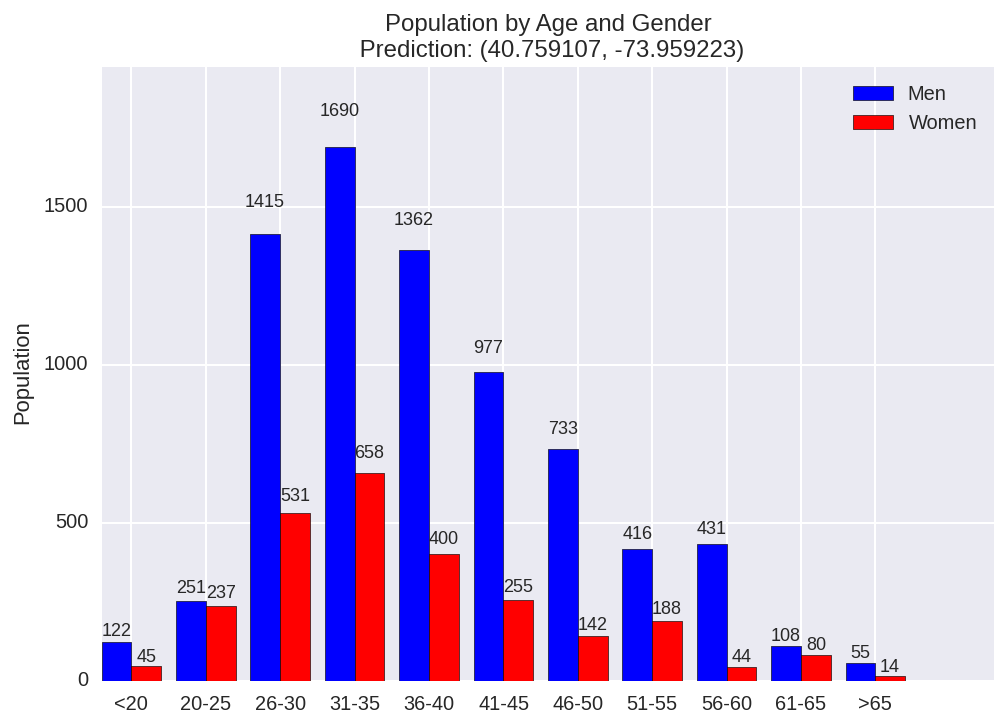

In [32]:
# plot the predict value
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 9
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, menpd, width, color='b')

rects2 = ax.bar(ind + width, womenpd, width, color='r')

ax.set_ylabel('Population')
ax.set_title('Population by Age and Gender \n Prediction: (40.759107, -73.959223)')
ax.set_xticks(ind + width)
ax.set_xticklabels(('<20','20-25', '26-30', '31-35', '36-40', '41-45','46-50','51-55','56-60','61-65','>65'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

ax.set_ybound(0, max([max(menpd),max(womenpd)])*1.15)


plt.show()

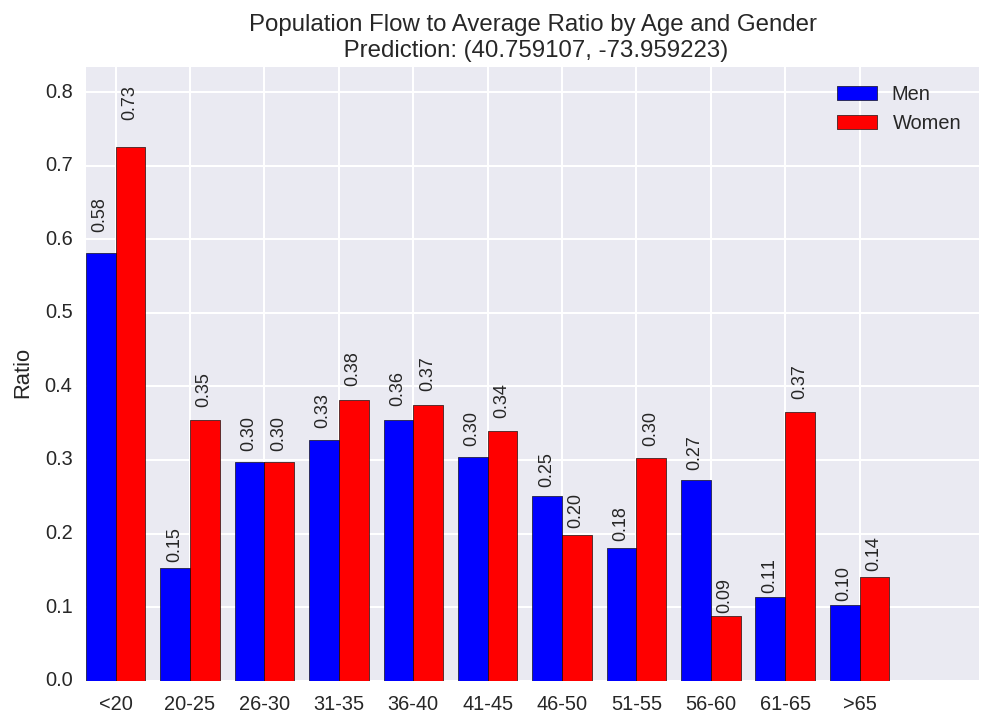

In [36]:
# plot the predict value to average ratio
import numpy as np
import matplotlib.pyplot as plt

N = 11

menratio = np.array(menpd, dtype=np.float)*1.0/np.array(averagemen, dtype=np.float)
womenratio = np.array(womenpd, dtype=np.float)*1.0/np.array(averagewomen, dtype=np.float)


ind = np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(ind, menratio, width, color='b')
rects2 = ax.bar(ind + width, womenratio, width, color='r')

ax.set_ylabel('Ratio')
ax.set_title('Population Flow to Average Ratio by Age and Gender \n Prediction: (40.759107, -73.959223)')
ax.set_xticks(ind + width)
ax.set_xticklabels(('<20','20-25', '26-30', '31-35', '36-40', '41-45','46-50','51-55','56-60','61-65','>65'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%0.2f' % float(height),
                ha='center', va='bottom',rotation=90)

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))

autolabel(rects1)
autolabel(rects2)

ax.set_ybound(0, max([max(menratio),max(womenratio)])*1.15)

plt.show()